# 3a- Training with built-in LinearLearner <a class="anchor" id="top"></a>
* [Introduction](#intro)
* [Setup](#setup)
* [Estimator creation](#estim)
* [Evaluate training result](#eval)
    * [Create endpoint to test model](#endpoint)
    * [ Analysis of training results](#analysis)
* [Cleanup resources](#clean)

## Introduction <a class="anchor" id="intro"></a>
In this notebook, we will train a Linear Learner model, evaluate the training performance, and output model artifacts.
Linear Learner is based on logistic regression models.
We will be using Amazon's built-in Linear Learner implementation which has an internal model jyperparameter tuning mechanism.

## Setup <a class="anchor" id="setup"></a>
First, we import Sageamker SDK dependencies as well as modules used in application below.
We also get relevant sessions and read in local environment data.

In [ ]:
import json
import uuid
import boto3
import random
import tarfile
import pickle as pkl
import datetime as dt
import sagemaker as sm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
sns.set_style("darkgrid")

In [ ]:
sm_session = sm.Session()
role = sm.get_execution_role()
boto3_session = boto3.session.Session()
now = dt.datetime.now().strftime(r"%Y%m%dT%H%M%S")

In [ ]:
# Get boto3 session attributes.
account = boto3_session.client("sts").get_caller_identity()["Account"]
region = boto3_session.region_name

# Create clients to access S3.
s3_client = boto3_session.client("s3")
s3_resource = boto3_session.resource("s3")

In [ ]:
# Retrieve data and model bucket names.
with open("/home/ec2-user/.aiml-bb/stack-data.json", "r") as f:
    data = json.load(f)
    data_bucket = data["data_bucket"]
    model_bucket = data["model_bucket"]

## Estimator creation <a class="anchor" id="estim"></a>
We can now create the Linear Learner estimator, using Amazon's built-in implementation.
Because the model is managed for us, there is little to do in way of setup.

In [5]:
# Get Linear Learner container image for current region.
ll_container_image = sm.image_uris.retrieve("linear-learner", region)

# Create a unique training job name.
training_job_name = f"'ll-{str(uuid.uuid4())[:8]}"

In [6]:
train_input = sm.inputs.TrainingInput(
    s3_data=f"s3://{data_bucket}/preprocessing_output/train/", 
    content_type="text/csv"
)
validation_input = sm.inputs.TrainingInput(
    s3_data=f"s3://{data_bucket}/preprocessing_output/validation/",
    content_type="text/csv"
)

In [7]:
# Create estimator running the Linear Learner container.
ll_estimator = sm.estimator.Estimator(
    ll_container_image,
    role, 
    instance_count=1, 
    instance_type="ml.m5.4xlarge",
    volume_size=20,
    output_path=f"s3://{model_bucket}/sagemaker-linear-learner/"
)

In [ ]:
# Define starting hyperparameters for the model.
ll_estimator.set_hyperparameters(
    predictor_type="binary_classifier",
    binary_classifier_model_selection_criteria="precision_at_target_recall",
)
ll_estimator.fit(
    {"train": train_input, "validation": validation_input}
)

In [ ]:
# Copy model to location we can reference in other notebooks.
copy_source = {
    "Bucket": model_bucket,
    "Key": ll_estimator.model_data.replace(f"s3://{model_bucket}/", "")
}
s3_resource.Bucket(model_bucket).copy(
    copy_source, 
     "sagemaker-linear-learner-latest/model.tar.gz"
)

## Evaluate training results <a class="anchor" id="eval"></a>
Lastly, we evaluate the results of training against the testing data set.
To test this model, we will create and endpoint that we can send the testing data to synchronously.
Note that this data set is not included in training and has never been seen by the model.

### Create endpoint to test model <a class="anchor" id="endpoint"></a>

In [13]:
# Create model and endpoint from best fitted estimator above.
ll_model = sm.model.Model(
    image_uri=ll_container_image,
    model_data=f"s3://{model_bucket}/sagemaker-linear-learner-latest/model.tar.gz",
    role=role
)
endpoint_name = f"ll-test-endpt-{now}"
ll_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.xlarge",
    endpoint_name=endpoint_name
)

-----!

In [14]:
# Connect a predictor to the endpoint for inference.
ll_predictor = sm.predictor.Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sm_session,
    serializer=sm.serializers.CSVSerializer(
        content_type="text/csv"
    )
)

In [ ]:
# Iterate over testing data and compute statistics.
list_objs_response = s3_client.list_objects_v2(
    Bucket=data_bucket, 
    Prefix="preprocessing_output/train"
)

# Arrays to keep track of results.
test_actuals = []
test_predictions = []
for obj in list_objs_response["Contents"]:
    
    # Iterate over lines in object contents via stream.
    obj_resource = s3_resource.Object(data_bucket, obj["Key"])
    for line in obj_resource.get()["Body"].iter_lines():
        target, features = line.decode("utf-8").split(",", maxsplit=1)
        features = features.strip()
        predict_response = json.loads(ll_predictor.predict(features))
        prediction = predict_response["predictions"][0]["predicted_label"]
        
        test_actuals.append(float(target))
        test_predictions.append(float(prediction))

### Analysis of training results <a class="anchor" id="analysis"></a>
Lastly, we analyze the performance of the model against the testing data set.

In [21]:
# Wrap lists in numpy arrays for analysis.
test_actuals_np = np.array(test_actuals)
test_predictions_np = np.array(test_predictions)

In [22]:
len(test_actuals_np)

1510649

In [23]:
# Compute summary statistics on perfomance.
performance_statistics = {
    "accuracy": metrics.accuracy_score(test_actuals_np, test_predictions_np),
    "precision": metrics.precision_score(test_actuals_np, test_predictions_np),
    "recall": metrics.recall_score(test_actuals_np, test_predictions_np),
    "f1": metrics.f1_score(test_actuals_np, test_predictions_np),
    "auc": metrics.roc_auc_score(test_actuals_np, test_predictions_np),
}
print(json.dumps(performance_statistics, indent=4))

{
    "accuracy": 0.5514808535933894,
    "precision": 0.478880500931949,
    "recall": 0.809270207917927,
    "f1": 0.60170556114984,
    "auc": 0.5875591699275642
}


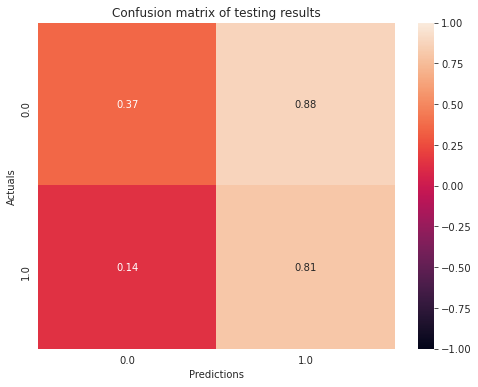

In [24]:
# Compute confusion matrix.
confusion_df = pd.crosstab(
    test_actuals_np, 
    test_predictions_np, 
    rownames=["Actuals"], 
    colnames=["Predictions"]
)
norm_confusion_df = confusion_df / confusion_df.sum(axis=1)

# Show confusion matrix.
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    norm_confusion_df, 
    vmin=-1.0, vmax=1.0, annot=True, fmt=".2f", 
    ax=ax
)
ax.set_title("Confusion matrix of testing results")
plt.show()

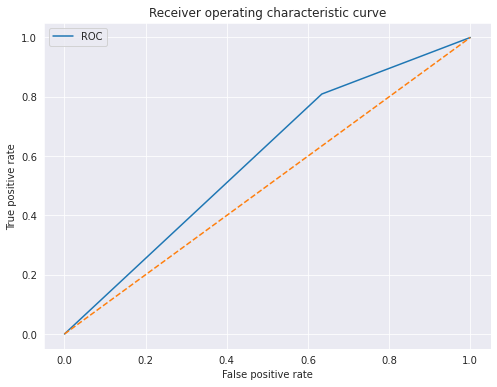

In [25]:
# Compute ROC curve.
fpr, tpr, thresholds = metrics.roc_curve(test_actuals_np, test_predictions_np)

# Plot ROC matrix.
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, label="ROC")
ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Receiver operating characteristic curve")
ax.legend()
plt.show()

## Cleanup resources <a class="anchor" id="clean"></a>
Because this is a temporary project, delete the endpoint.

In [26]:
ll_predictor.delete_endpoint()